# Experiment: Online Feature Selection

In this experiment, we use float to compare the effect of different online feature selection techniques.

In [1]:
# Optional: Rebase the file path.
# Note that you may also provide explicit file paths and avoid this step.
import os
os.chdir(os.getcwd()[:-18])

In [2]:
# Import modules
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from sklearn.preprocessing import MinMaxScaler
from skmultiflow.trees import HoeffdingTreeClassifier

# Import float modules
from float.data import DataLoader
from float.data.preprocessing import SklearnScaler
from float.feature_selection.evaluation import FeatureSelectionEvaluator
from float.feature_selection.evaluation.measures import nogueira_stability
from float.feature_selection import FIRES, OFS
from float.pipeline import PrequentialPipeline
from float.prediction.evaluation import PredictionEvaluator
from float.prediction.skmultiflow import SkmultiflowClassifier
import float.visualization as fvis

In [3]:
# - Create a data loader object -
# We load the Gas Sensor data set and specify a sklearn MinMaxScaler for the normalization.
data_loader = DataLoader(path='float/data/datasets/bank_marketing.csv',  # This path might have to be adjusted!
                         target_col=-1,
                         scaler=SklearnScaler(MinMaxScaler())
                         )

# - Create the predictor objects. -
# We use the default parameters of the skmultiflow implementation of the Hoeffding Tree.
predictors = [SkmultiflowClassifier(model=HoeffdingTreeClassifier(), 
                                  classes=data_loader.stream.target_values),
              SkmultiflowClassifier(model=HoeffdingTreeClassifier(), 
                                  classes=data_loader.stream.target_values)]  # We use the same predictor for each feature selection method

# - Create evaluator objects corresponding to the classifiers. -
# These evaluators will compute and store the performance measures when running the pipeline.
# For illustration, we just compute the zero_one_loss.
pred_evaluators = [PredictionEvaluator(measure_funcs=[zero_one_loss]),
                   PredictionEvaluator(measure_funcs=[zero_one_loss])]

# - Create feature selection models -
# We compare the FIRES and OFS feature selection methods. 
# Since the Hoeffding Tree cannot deal with arbitrary patterns of missing data, we use a Gaussian-baseline to replace non-selected features.
# We set the number of selected feature to 10.
ref_sample, _ = data_loader.stream.next_sample(50)
data_loader.stream.reset()  # We reset the stream after loading a reference sample for the computation of the baseline.

feature_selectors = [FIRES(n_total_features=data_loader.stream.n_features,
                           n_selected_features=10,
                           classes=data_loader.stream.target_values,
                           baseline='gaussian',
                           ref_sample=ref_sample),
                    OFS(n_total_features=data_loader.stream.n_features,
                        n_selected_features=10,
                        baseline='gaussian',
                        ref_sample=ref_sample)]

# - Create evaluator objects corresponding to each feature selector - 
# We compute the Nogueira stability, which measures the variability of the selected feature set between subsequent time steps.
fs_evaluators = [FeatureSelectionEvaluator([nogueira_stability]),
                 FeatureSelectionEvaluator([nogueira_stability])]

# - Run the Experiments for each online feature selector -
for predictor, pred_eval, fs_selector, fs_eval in zip(predictors, pred_evaluators, feature_selectors, fs_evaluators):
    # - Create a prequential pipeline -
    # We use a batch-incremental scheme, processing the data in batches of size 100.
    # Moreover, we set a random state for reproducibility.
    pipeline = PrequentialPipeline(data_loader=data_loader,
                                   predictor=predictor,
                                   prediction_evaluator=pred_eval,
                                   feature_selector=fs_selector,
                                   feature_selection_evaluator=fs_eval,
                                   batch_size=100,
                                   n_max=data_loader.stream.n_samples,  # We use all observations
                                   random_state=0)
    
    pipeline.run()

Pretrain the predictor with 100 observation(s).
[====================] 100%
################################## SUMMARY ##################################
Evaluation has finished after 15.399999141693115s
Data Set float/data/datasets/bank_marketing.csv
The pipeline has processed 45211 instances in total, using batches of size 100.
----------------------
Feature Selection (10/16 features):
| Model   |   Avg. Comp. Time |   Avg. nogueira_stability |
|---------|-------------------|---------------------------|
| FIRES   |        0.00162846 |                  0.993068 |
----------------------
Prediction:
| Model                   |   Avg. Test Comp. Time |   Avg. Train Comp. Time |   Avg. zero_one_loss |
|-------------------------|------------------------|-------------------------|----------------------|
| HoeffdingTreeClassifier |             0.00619277 |               0.0228777 |             0.118996 |
#############################################################################
Pretrain t

C:\Users\johan\Documents\float\float\feature_selection\base_feature_selector.py:124: UserWarning: The weight vector contains negative values. The sbsolute weights will be used for feature selection.
  warnings.warn("The weight vector contains negative values. The sbsolute weights will be used for "


[====================] 100%
################################## SUMMARY ##################################
Evaluation has finished after 14.485904216766357s
Data Set float/data/datasets/bank_marketing.csv
The pipeline has processed 45211 instances in total, using batches of size 100.
----------------------
Feature Selection (10/16 features):
| Model   |   Avg. Comp. Time |   Avg. nogueira_stability |
|---------|-------------------|---------------------------|
| OFS     |       0.000997481 |                  0.679794 |
----------------------
Prediction:
| Model                   |   Avg. Test Comp. Time |   Avg. Train Comp. Time |   Avg. zero_one_loss |
|-------------------------|------------------------|-------------------------|----------------------|
| HoeffdingTreeClassifier |             0.00763969 |               0.0201624 |             0.108751 |
#############################################################################


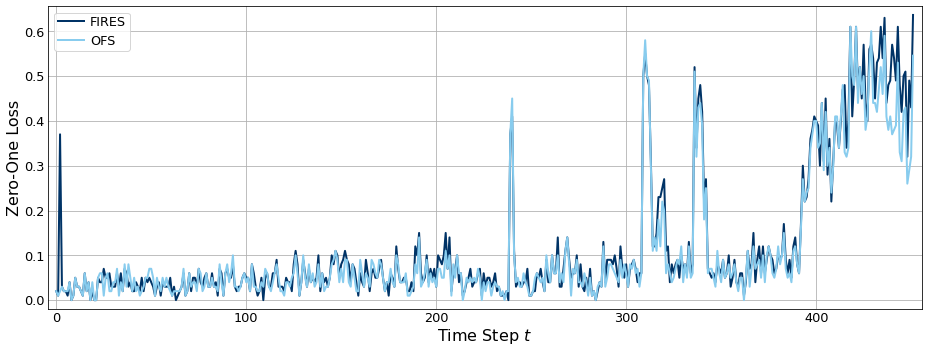

In [4]:
# - Illustrate results - 
# The float visualizer contains standard plot types like line, scatter or bar, but also provides special plots..
# ..for concept drift detection and online feature selection. 
# We illustrate the visualization of online feature selection experiments in the following.

# - Plot the loss of the classifier for different feature selection methods -
ax = fvis.plot(measures=[evaluator.result['zero_one_loss']['measures'] for evaluator in pred_evaluators],
               legend_labels=['FIRES', 'OFS'],
               fig_size=(13, 5),
               y_label='Zero-One Loss')

#ax.set_title('Prequential Evaluation with Hoeffding Tree Classifier and Different Online Feature Selectors')  # The returned matplotlib object can be altered and further customized.

plt.savefig('float/experiments/zero_one_loss_feature_selection.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

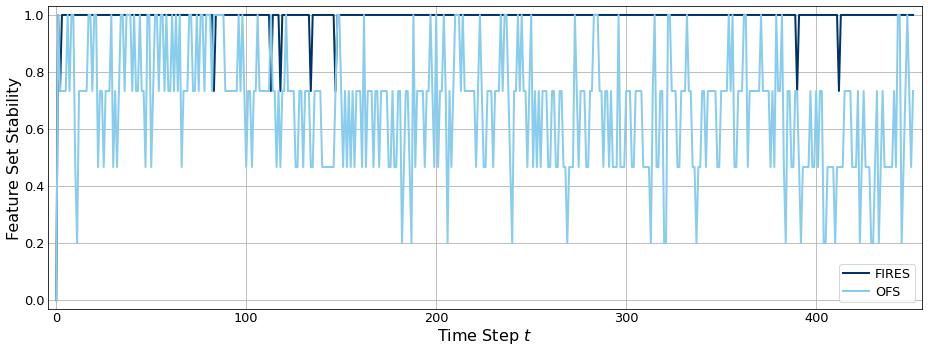

In [5]:
# - Plot the feature set stability the different feature selection methods -
ax = fvis.plot(measures=[evaluator.result['nogueira_stability']['measures'] for evaluator in fs_evaluators],
               legend_labels=['FIRES', 'OFS'],
               fig_size=(13, 5),
               y_label='Feature Set Stability')

#ax.set_title('Stability of Online Feature Selection Methods')

plt.savefig('float/experiments/nogueira_stability.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

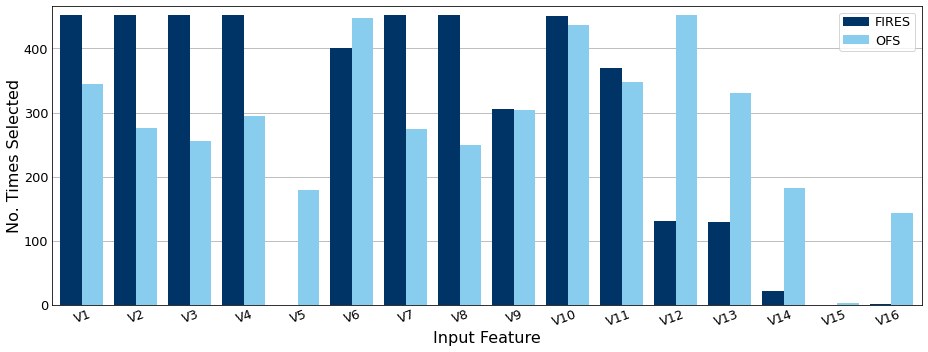

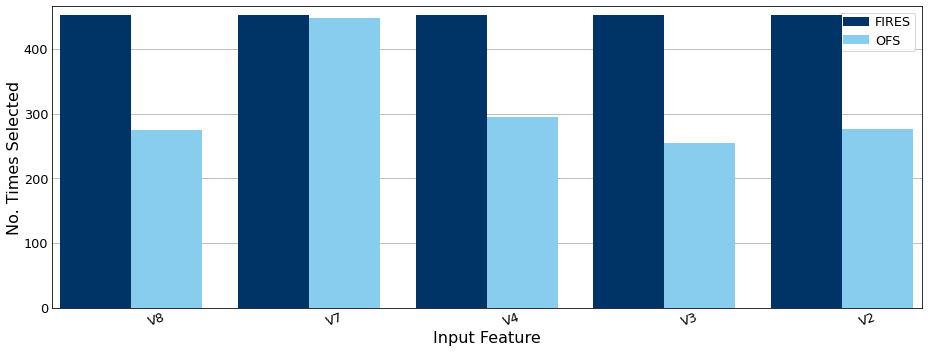

In [6]:
# - Compare the number of times each feature has been selected - 
# Float provides a special bar chart that can be used to compare the top features per model.
# We can either display all features in the original order, or a fix number of sorted top features.

# - Original Order - 
ax = fvis.feature_selection_bar(selected_features=[f_selector.selected_features_history for f_selector in feature_selectors],
                                model_names=['FIRES', 'OFS'],
                                feature_names=data_loader.stream.feature_names,
                                fig_size=(13, 5))
#ax.set_title('No. of Times Each Feature was Selected')
plt.savefig('float/experiments/feature_selection_bar.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

# - Sorted Top Features - 
# Here, float uses the first provided model as a reference to select the top n features
ax = fvis.feature_selection_bar(selected_features=[f_selector.selected_features_history for f_selector in feature_selectors],
                                model_names=['FIRES', 'OFS'],
                                feature_names=data_loader.stream.feature_names,
                                fig_size=(13, 5), 
                                top_n_features=5)

#ax.set_title('Top 5 Features According To Times Being Selected')
plt.savefig('float/experiments/feature_selection_bar_top5.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()


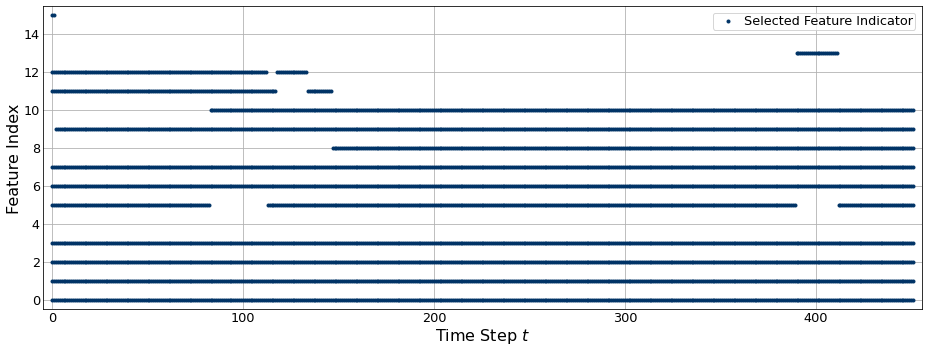

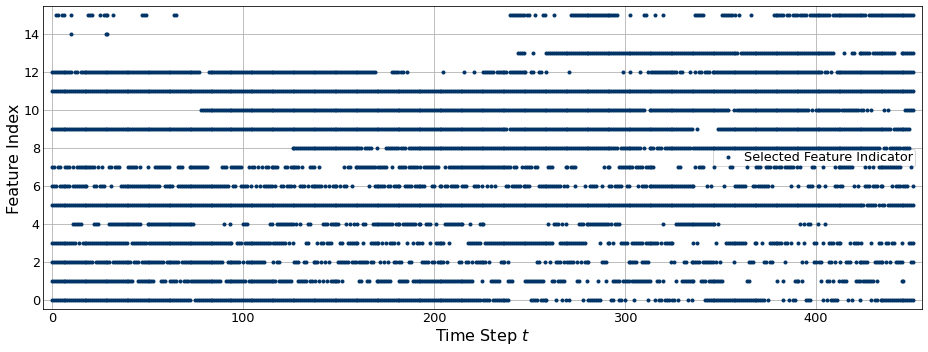

In [9]:
# - Plot selected features over time - 
# Float provides a special scatter plot that allows to illustrate the selected features over time.
# - FIRES model: -
ax = fvis.feature_selection_scatter(selected_features=feature_selectors[0].selected_features_history, 
                                    fig_size=(13, 5))

#ax.set_title('Selected Features of the FIRES method.')
plt.savefig('float/experiments/fires_scatter.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

# - OFS model: -

ax = fvis.feature_selection_scatter(selected_features=feature_selectors[1].selected_features_history, 
                                    fig_size=(13, 5))

#ax.set_title('Selected Features of the OFS method.')
plt.savefig('float/experiments/ofs_scatter.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()